In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
from skimage import io, color
from skimage.feature import hog

class BrainTumorDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        
        # Get all image and label filenames
        self.image_filenames = sorted(os.listdir(images_dir))
        self.label_filenames = sorted(os.listdir(labels_dir))
        
        
        # Ensure image and label filenames match (assuming they are named the same except for extensions)
        self.image_filenames = [filename for filename in self.image_filenames if filename.replace('.jpg', '.txt') in self.label_filenames]
        self.label_filenames = [filename.replace('.jpg', '.txt') for filename in self.image_filenames]
        

    def extract_hog_features(self,image):
        # Check if the image is already grayscale (2D array)
        if len(image.shape) == 2:  # Grayscale image (2D array)
            image_gray = image
        else:  # RGB image (3D array)
            image_gray = color.rgb2gray(image)  # Convert to grayscale

        features, hog_image = hog(image_gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)
        return features
        
    def __getitem__(self, idx):
        # Load image and label
        image_path = os.path.join(self.images_dir, self.image_filenames[idx])
        label_path = os.path.join(self.labels_dir, self.label_filenames[idx])
        
        image = Image.open(image_path).convert("RGB")  # Ensure image is in RGB format
        image_width, image_height = image.size  # Get image dimensions
        
        # Read the label (YOLO format)
        with open(label_path, 'r') as file:
            label_data = file.readlines()
        
        boxes = []
        for line in label_data:
            parts = line.strip().split()
            if len(parts) == 5:  # Expected format [class_id, x_center, y_center, width, height]
                class_id, x_center, y_center, width, height = map(float, parts)
                
                # Convert from YOLO format (normalized) to pixel coordinates
                x_min = (x_center - width / 2) 
                y_min = (y_center - height / 2) 
                x_max = (x_center + width / 2) 
                y_max = (y_center + height / 2) 
                
                boxes.append([class_id, x_min, y_min, x_max, y_max])
        
        # Convert to tensor format
        boxes = torch.tensor(boxes, dtype=torch.float32)

        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)
        
        image = image.permute(1, 2, 0).numpy()
        #feature = self.extract_hog_features(image)
        
        # Return image and corresponding bounding boxes
        return image, boxes
    
    def __len__(self):
        return len(self.image_filenames)


# Example usage:
images_dir_train = './BT_Dataset/images/train'
labels_dir_train = './BT_Dataset/labels/train'

images_dir_test = './BT_Dataset/images/test'
labels_dir_test = './BT_Dataset/labels/test'


# Define transforms to convert images to tensors
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to 256x256 (you can change the size)
    transforms.ToTensor(),  # Convert image to tensor
])


def collate_fn(batch):
    """
    Custom collate function to handle variable-sized labels.
    """
    images = []
    targets = []

    for img, boxes in batch:
        images.append(torch.tensor(img, dtype=torch.float32).permute(2, 0, 1))  # Ensure CHW format
        targets.append(boxes)

    # Stack images and return the list of targets as is
    images = torch.stack(images, dim=0)
    return images, targets
    

# Create dataset
train_dataset = BrainTumorDataset(images_dir_train, labels_dir_train, transform=transform)

# Update DataLoader with the custom collate_fn
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn
)

# Create dataset
test_dataset = BrainTumorDataset(images_dir_test, labels_dir_test, transform=transform)

# Create data loader
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn
)

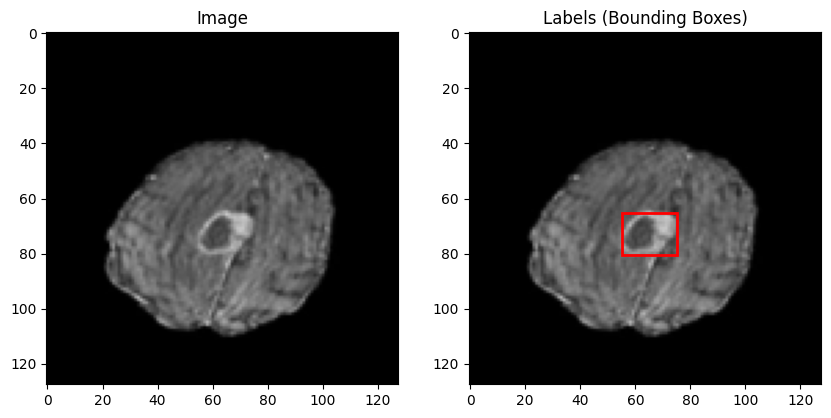

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

for images, labels in train_loader:
    # Assuming the batch size is > 1, so grab the first image
    image = images[0].squeeze(0).permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
    label = labels[0][0].numpy()  # Convert to numpy for displaying

    img_height, img_width = 128,128

    # Display image and bounding boxes
    plt.figure(figsize=(10, 5))
    
    # Display Image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')
    
    # Display Labels (Bounding Boxes)
    plt.subplot(1, 2, 2)
    plt.imshow(image)  # Show the image with bounding boxes
    
    
    x_min, y_min, x_max, y_max = (label[1] * img_width), (label[2] * img_height), (label[3] * img_width), (label[4] * img_height)
    # Add rectangle to the plot
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='red', facecolor='none')
    plt.gca().add_patch(rect)
    
    plt.title('Labels (Bounding Boxes)')
    
    plt.show()
    break  # Only display one sample

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, ToTensor

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(out_channels)  # Optional: Add BatchNorm for stability

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


        
# YOLOv1 Model with NMS
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, grid_size=7, num_boxes=2, num_classes=1, conf_threshold=0.5, nms_iou_threshold=0.4):
        super(Yolov1, self).__init__()
        self.grid_size = grid_size
        self.num_boxes = num_boxes
        self.num_classes = num_classes
        self.conf_threshold = conf_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.darknet = self._create_conv_layers(in_channels)
        self.fcs = self._create_fc_layers()

    def _create_conv_layers(self, in_channels):
        layers = []
        architecture = [
            (64, 7, 2, 3),  # Conv1
            "M",             # Max Pool1
            (192, 3, 1, 1),  # Conv2
            "M",             # Max Pool2
            (128, 1, 1, 0),  # Conv3
            (256, 3, 1, 1),  # Conv4
            (256, 1, 1, 0),  # Conv5
            (512, 3, 1, 1),  # Conv6
            "M",             # Max Pool3
        ]
        for x in architecture:
            if type(x) == tuple:
                layers.append(
                    CNNBlock(in_channels, x[0], kernel_size=x[1], stride=x[2], padding=x[3])
                )
                in_channels = x[0]
            elif x == "M":
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        return nn.Sequential(*layers)

    def _create_fc_layers(self):
        dummy_input = torch.zeros(1, 3, 128, 128)  # Updated input size (128x128)
        output_after_conv = self.darknet(dummy_input)
        conv_output_size = output_after_conv.numel()
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_output_size, 4096),
            nn.ReLU(),
            nn.Linear(4096, self.grid_size * self.grid_size * (self.num_classes + self.num_boxes * 5))
        )

    def forward(self, x):
        x = self.darknet(x)
        x = self.fcs(x)

        # Reshape the output into grid_size x grid_size x (num_classes + num_boxes * 5)
        x = x.view(-1, self.grid_size, self.grid_size, self.num_classes + self.num_boxes * 5)
        
        # Apply NMS to the raw predictions
        predictions = self.apply_nms(x)
        
        return predictions

    def apply_nms(self, predictions):
        # Prepare the predictions for NMS
        box_preds = predictions[..., :5]  # (x, y, w, h, confidence)
        class_preds = predictions[..., 5:]

        # Create mask based on confidence threshold
        conf_mask = box_preds[..., 4] > self.conf_threshold
        box_preds = box_preds[conf_mask]
        class_preds = class_preds[conf_mask]

        final_boxes = []
        for class_idx in range(class_preds.size(-1)):  # Loop over classes
            class_scores = class_preds[..., class_idx]
            if class_scores.size(0) == 0:
                continue

            # Apply NMS to filter out overlapping bounding boxes
            keep_idx = nms(box_preds[..., :4], class_scores, self.nms_iou_threshold)
            if keep_idx.size(0) > 0:
                final_boxes.append(box_preds[keep_idx])

        if final_boxes:
            final_boxes = torch.cat(final_boxes, dim=0)
            # Ensure we only have one box (most confident)
            final_boxes = final_boxes[final_boxes[..., 4].argmax()]
            final_boxes = final_boxes.unsqueeze(0)  # Add batch dimension
        else:
            final_boxes = torch.zeros(1, 5, device=predictions.device)

        return final_boxes

In [112]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision.ops import nms  # Use the torchvision nms function

# Hyperparameters
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 0.00001
EPOCHS = 50

# Model, Loss, Optimizer
model = Yolov1().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()

# Best validation loss tracker
best_val_loss = float('inf')
best_model_path = './best_yolov1_model.pth'

def non_max_suppression(predictions, conf_threshold=0.5, iou_threshold=0.4):
    box_preds = predictions[:, :5]  # (x, y, w, h, confidence)
    class_preds = predictions[:, 5:]

    conf_mask = box_preds[:, 4] > conf_threshold
    box_preds = box_preds[conf_mask]
    class_preds = class_preds[conf_mask]

    final_boxes = []
    for class_idx in range(class_preds.size(1)):
        class_scores = class_preds[:, class_idx]
        if class_scores.size(0) == 0:
            continue
        
        keep_idx = nms(box_preds[:, :4], class_scores, iou_threshold)
        final_boxes.append(box_preds[keep_idx])

    if final_boxes:
        final_boxes = torch.cat(final_boxes, dim=0)
    else:
        final_boxes = torch.zeros(1, 5, device=DEVICE)

    return final_boxes

# Training Loop
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(DEVICE)  # Move images to the device
        if isinstance(labels, list):
            labels = labels[0]  # Assuming there is only one tensor in the list
        labels = labels.to(DEVICE)  # Move labels to device

        # Forward pass
        optimizer.zero_grad()
        predictions = model(images)  # Predictions from the model should already require gradients

        predictions = predictions.requires_grad_()

        # Use raw predictions (without NMS) for loss calculation during training
        loss = loss_fn(predictions, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{EPOCHS}], Loss: {running_loss / len(train_loader):.4f}")

    # Validation step (if you have a validation set)
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels in test_loader:
            val_images = val_images.to(DEVICE)
            if isinstance(val_labels, list):
                val_labels = val_labels[0]
            val_labels = val_labels.to(DEVICE)

            val_predictions = model(val_images)
            val_loss += loss_fn(val_predictions, val_labels).item()

    avg_val_loss = val_loss / len(test_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")

    # Save the model if validation loss is improved
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Model saved to {best_model_path}")

Shape after convolutional layers: torch.Size([1, 512, 8, 8])
Epoch [1/50], Loss: 0.2923
Validation Loss: 0.2547
Model saved to ./best_yolov1_model.pth
Epoch [2/50], Loss: 0.2359
Validation Loss: 0.1637
Model saved to ./best_yolov1_model.pth
Epoch [3/50], Loss: 0.1362
Validation Loss: 0.2100
Epoch [4/50], Loss: 0.1143
Validation Loss: 0.1670
Epoch [5/50], Loss: 0.0926
Validation Loss: 0.1847
Epoch [6/50], Loss: 0.0848
Validation Loss: 0.1405
Model saved to ./best_yolov1_model.pth
Epoch [7/50], Loss: 0.0870
Validation Loss: 0.1622
Epoch [8/50], Loss: 0.0775
Validation Loss: 0.1575
Epoch [9/50], Loss: 0.0843
Validation Loss: 0.1917
Epoch [10/50], Loss: 0.0925
Validation Loss: 0.1491
Epoch [11/50], Loss: 0.1247
Validation Loss: 0.1649
Epoch [12/50], Loss: 0.1116
Validation Loss: 0.1775
Epoch [13/50], Loss: 0.1083
Validation Loss: 0.2197
Epoch [14/50], Loss: 0.1067
Validation Loss: 0.1058
Model saved to ./best_yolov1_model.pth
Epoch [15/50], Loss: 0.1036
Validation Loss: 0.1428
Epoch [16/50

Shape after convolutional layers: torch.Size([1, 512, 8, 8])


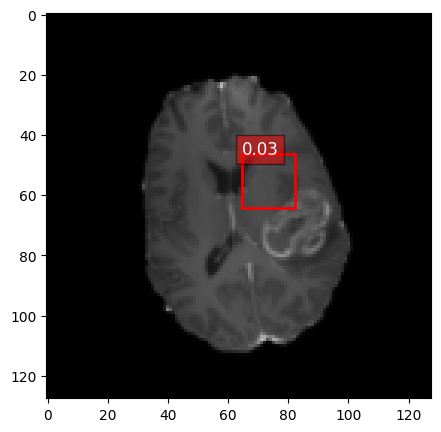

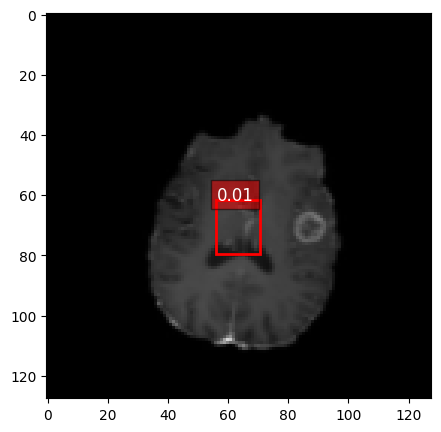

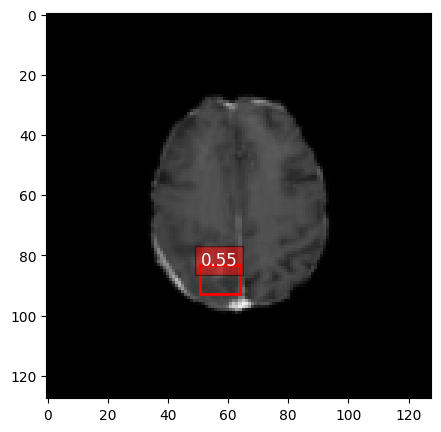

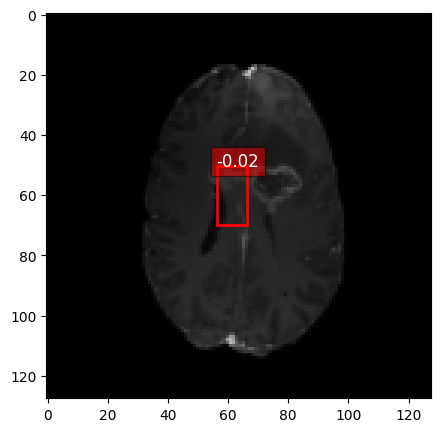

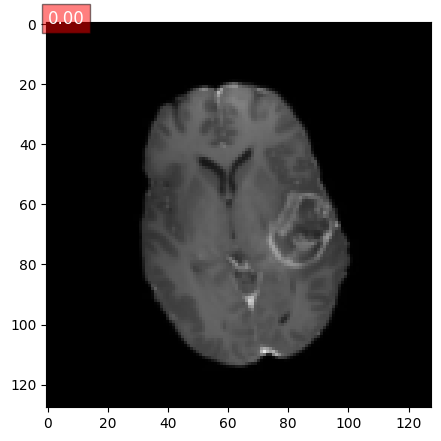

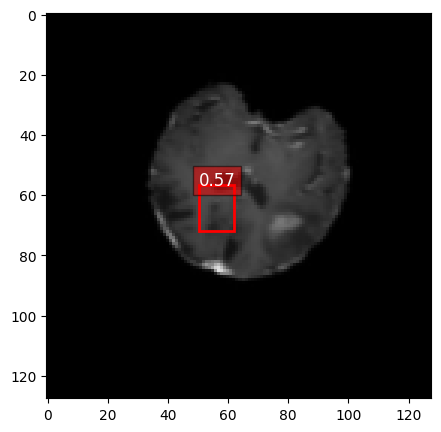

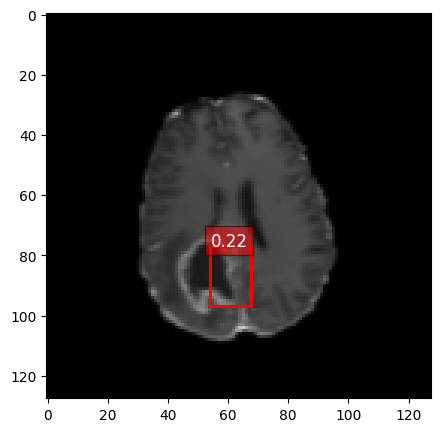

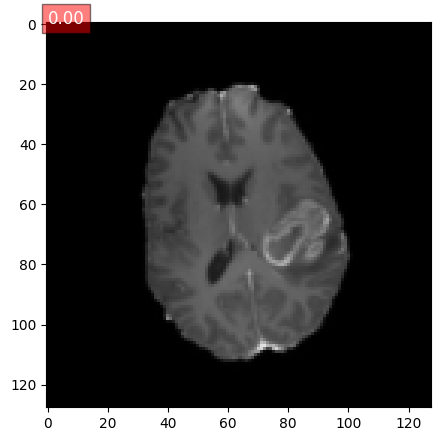

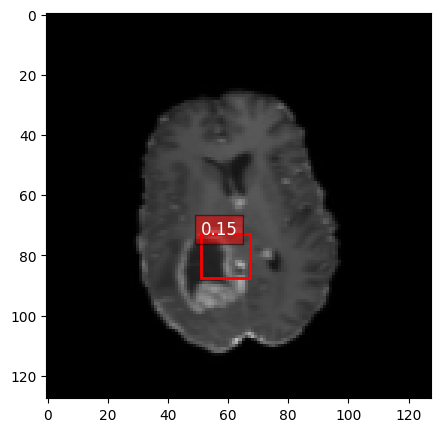

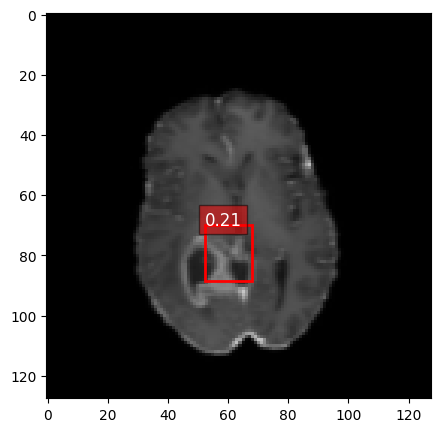

In [141]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.ops import nms

# Assuming you have a model and a test_loader
test = Yolov1().to(DEVICE)
test.load_state_dict(torch.load('./best_yolov1_model.pth'))
# Set the model to evaluation mode
test.eval()

# Define a function to plot bounding boxes
def plot_bboxes(image, bbox, score):
    # Check if there are any bounding boxes to plot
    if bbox.size(0) == 0:
        print("No boxes detected.")
        return

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(image)  # Convert CHW to HWC format

    x_min, y_min, x_max, y_max = bbox.tolist()
    x_min, y_min, x_max, y_max = x_min * 128, y_min * 128, x_max * 128, y_max * 128
    ax.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                               fill=False, color="red", linewidth=2))
    ax.text(x_min, y_min, f'{score.item():.2f}', fontsize=12, color='white',  # Use .item() to get the scalar value
            bbox=dict(facecolor='red', alpha=0.5))

    plt.show()

def scale_bboxes(bboxes, orig_w, orig_h, resized_w, resized_h):
    # Calculate the scale factors
    scale_x = orig_w / resized_w
    scale_y = orig_h / resized_h
    
    # Scale the bounding boxes
    bboxes[:, 0] *= scale_x  # x_min
    bboxes[:, 1] *= scale_y  # y_min
    bboxes[:, 2] *= scale_x  # x_max
    bboxes[:, 3] *= scale_y  # y_max
    
    return bboxes

def non_max_suppression(predictions, conf_threshold=0.5, iou_threshold=0.4, orig_w=None, orig_h=None, resized_w=None, resized_h=None):
    # Extract bounding box predictions and confidence scores
    box_preds = predictions[1:]  # (x_min, y_min, x_max, y_max)
    confidences = predictions[0]  # Confidence scores

    # Apply confidence thresholding
    conf_mask = confidences > conf_threshold
    box_preds = box_preds[conf_mask]
    confidences = confidences[conf_mask]

    # Apply non-max suppression
    keep_idx = nms(box_preds, confidences, iou_threshold)
    final_boxes = box_preds[keep_idx]

    # Scale bounding boxes back to the original image size
    if orig_w and orig_h and resized_w and resized_h:
        final_boxes = scale_bboxes(final_boxes, orig_w, orig_h, resized_w, resized_h)

    # If no boxes are kept, return an empty tensor
    if final_boxes.size(0) == 0:
        final_boxes = torch.zeros(1, 4, device=predictions.device)

    return final_boxes

# Iterate over the test dataset
num_plot_img = 10
with torch.no_grad():
    for images, targets in test_loader:
        images = images.to(DEVICE)
        
        # Get the original image dimensions
        orig_w, orig_h = images.shape[3], images.shape[2]
        
        # Resize images for inference
        resized_images = torch.nn.functional.interpolate(images, size=(416, 416), mode='bilinear', align_corners=False)
        resized_w, resized_h = resized_images.shape[3], resized_images.shape[2]

        # Forward pass
        outputs = test(images)  # Assuming the model outputs bounding boxes and class scores

        # Apply NMS on predictions
        predictions = outputs  # Assuming outputs are in the form: [boxes, confidences, class_probs]
        predictions = predictions.flatten()
        
        selected_boxes = predictions[1:]  # (x_min, y_min, x_max, y_max)
        selected_scores = predictions[0]  # Confidence scores

        if num_plot_img > 0:
            # Plot bounding boxes on the first image in the batch
            plot_bboxes(images.squeeze(0).cpu().numpy().transpose(1, 2, 0), selected_boxes, selected_scores)
            num_plot_img -= 1